# Compute Correlation

This script analyzes the correlation between the baseline ViFi-CLIP model and human ratings. The focus is not on comparing different ViFi models, but rather on understanding the detailed relationship between model predictions and human evaluations. The following steps are:

### Visualizations
- **Histogram of ViFi-CLIP and Human Ratings**: Visualizes the distribution of ratings for both the model and humans.
- **Scatter Plot**: Displays the relationship between the model's predictions and human ratings, helping to assess how closely the model's behavior matches human evaluations.
- **Bland-Altman Plot**: Analyzes whether the model consistently evaluates differently from humans, highlighting any systematic biases or differences.

### GPT Prompt Classification Analysis
The results of the GPT prompt classification are also analyzed. For each category assigned by the model, the correlation with human ratings is computed, to find out how well the model’s outputs align with human judgments across different categories.

### Qualitative Evaluation
For qualitative evaluation, the script prints data points with the most differences between ViFi-CLIP predictions and human ratings.


Import libraries.

In [ ]:
#!pip install --upgrade pandas seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm

from scipy import stats
from sklearn.preprocessing import MinMaxScaler

In [3]:
# given directory of cross validation, get mean score
def mean_predictions_from_cv(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            all_data.append(df)

    combined_df = pd.concat(all_data, ignore_index=True)
    mean_scores = combined_df.groupby(["id", "turn"], as_index=False)["score"].mean()
    return mean_scores

In [6]:
human = pd.read_csv("annotations_mean_3.csv")
vifi_mean = mean_predictions_from_cv("crossvalidation/vitb16_2_humanedit")

merged_df = pd.merge(vifi_mean, human, on=["turn", "id"])

### Distribution of Ratings

For the predicted ViFi-CLIP and human scores.

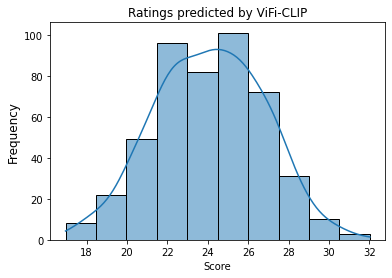

In [7]:
# plot a histogram for predicted ViFi scores

sns.histplot(merged_df["score"], bins=10, kde=True)

plt.title("Ratings predicted by ViFi-CLIP")
plt.xlabel("Score")
plt.ylabel("Frequency", fontsize=12)

plt.savefig("plots/histogram_vifi.png", dpi=300, bbox_inches="tight")
plt.show()

In [8]:
vifi_mean["score"].describe()

count    528.000000
mean      24.102553
std        2.668993
min       16.953200
25%       22.170100
50%       24.156200
75%       25.962400
max       32.022000
Name: score, dtype: float64

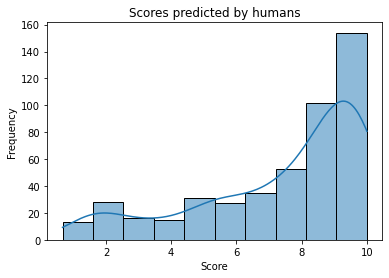

In [9]:
# plot a histogram of human ratings for the aspect "overall impression"

sns.histplot(human["overall"], bins=10, kde=True)

plt.title("Scores predicted by humans")
plt.xlabel("Score")
plt.ylabel("Frequency")

plt.show()

In [10]:
human["overall"].describe()

count    474.00000
mean       7.41916
std        2.57254
min        0.66700
25%        6.00000
50%        8.33300
75%        9.33300
max       10.00000
Name: overall, dtype: float64

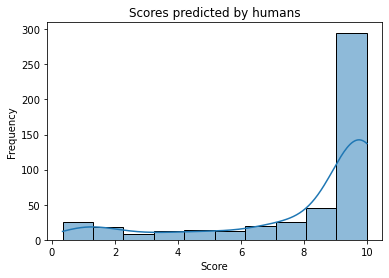

In [11]:
# plot a histogram of human ratings for the aspect "alignment"

sns.histplot(human["alignment"], bins=10, kde=True)

plt.title("Scores predicted by humans")
plt.xlabel("Score")
plt.ylabel("Frequency")

plt.show()

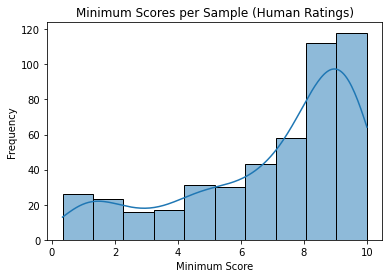

In [38]:
# plot a histogram of human ratings for the minimum value across all aspects for each sample

human["min_score"] = human[["alignment", "quality", "consistency", "overall"]].min(
    axis=1
)

sns.histplot(human["min_score"], bins=10, kde=True)

plt.title("Minimum Scores per Sample (Human Ratings)")
plt.xlabel("Minimum Score")
plt.ylabel("Frequency")

plt.show()

## Spearman correlation

In [39]:
def get_correlation_df(merged_df):
    correlation_results = []

    merged_df = merged_df.dropna(
        subset=["score", "alignment", "quality", "consistency", "overall"]
    )

    for col in merged_df.columns:
        if col in ["alignment", "quality", "consistency", "overall"]:

            spearman_corr, spearman_p_value = stats.spearmanr(
                merged_df["score"], merged_df[col]
            )
            correlation_results.append(
                {
                    "df1": "score",
                    "df2": col,
                    "spearman_corr": spearman_corr,
                    "spearman_p_value": spearman_p_value,
                }
            )

    correlation_results_df = pd.DataFrame(correlation_results)
    return correlation_results_df

In [40]:
get_correlation_df(merged_df)

,df1,df2,spearman_corr,spearman_p_value
0,score,alignment,0.115290,0.012012
1,score,quality,0.025036,0.586641
2,score,consistency,0.049165,0.285426
3,score,overall,0.094604,0.039509


## Bland Altman Plots

In [41]:
def bland_altman_plot(df1, df2, metric, ax):
    means = (merged_df["score"] + merged_df[metric]) / 2
    differences = merged_df["score"] - merged_df[metric]  # score - metric

    mean_diff = np.mean(differences)
    std_diff = np.std(differences)
    loa_upper = mean_diff + 1.96 * std_diff
    loa_lower = mean_diff - 1.96 * std_diff

    ax.scatter(means, differences, alpha=0.5)
    ax.axhline(mean_diff, color="red", linestyle="--", label="Mean Diff")
    ax.axhline(loa_upper, color="blue", linestyle="--", label="Upper LoA")
    ax.axhline(loa_lower, color="blue", linestyle="--", label="Lower LoA")

    ax.set_title(f"ViFi-CLIP vs. {metric}", fontsize=16)
    ax.set_xlabel(f"Mean", fontsize=14)
    ax.set_ylabel(f"Difference", fontsize=14)
    ax.legend(fontsize=11)


def plot_all_bland_altman(
    df1, df2, metrics=["alignment", "quality", "consistency", "overall"]
):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        bland_altman_plot(df1, df2, metric, axes[i])

    plt.tight_layout()
    plt.savefig(f"plots/bland_altman.png", dpi=300, bbox_inches="tight")
    plt.show()

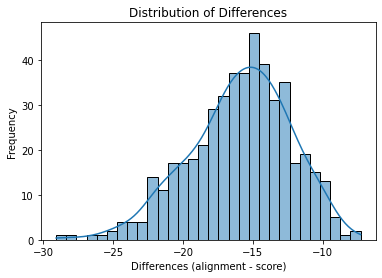

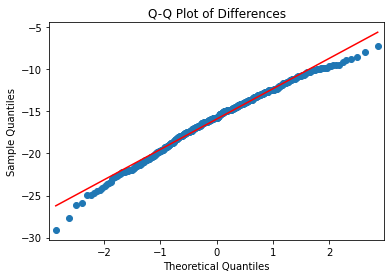

In [43]:
# Bland Altman prerequisite: check if mean value differences follow gaussian distribution
diffs = merged_df["alignment"] - merged_df["score"]
sns.histplot(diffs, kde=True, bins=30)
plt.xlabel("Differences (alignment - score)")
plt.ylabel("Frequency")
plt.title("Distribution of Differences")
plt.show()

sm.qqplot(diffs, line="s")
plt.title("Q-Q Plot of Differences")
plt.show()

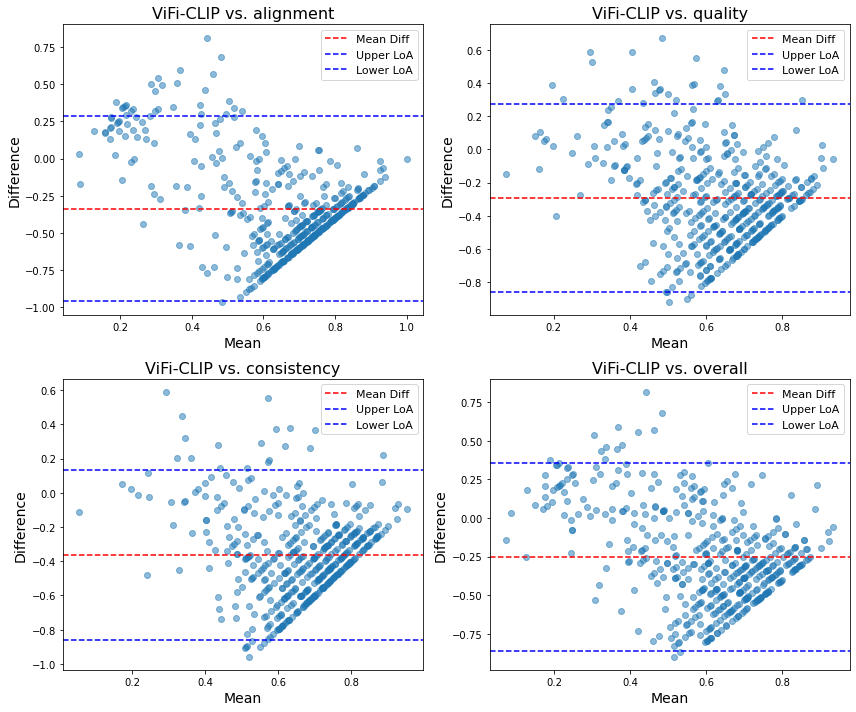

In [56]:
# merged_df = pd.merge(human, vifi_mean, on=['turn', 'id'])
scaler = MinMaxScaler()
merged_df[["score", "alignment", "quality", "consistency", "overall"]] = (
    scaler.fit_transform(
        merged_df[["score", "alignment", "quality", "consistency", "overall"]]
    )
)
plot_all_bland_altman(
    merged_df[["turn", "id", "alignment", "quality", "consistency", "overall"]],
    merged_df[["turn", "id", "score"]],
)

- Systematic Bias: score is consistently lower than alignment -> metrics are not interchangeable
- The difference between score and alignment increases for higher values -> heteroscedasticity (the disagreement grows with increasing scores)

## Scatter Plots

Compute a standard scatter plot with the option to highlight the most influential points.

In [57]:
original_corr = merged_df["score"].corr(merged_df["alignment"])

# test influence of each point
influence = []
for i in range(len(merged_df)):
    temp_df = merged_df.drop(i)
    new_corr = temp_df["score"].corr(temp_df["alignment"])
    influence.append(abs(original_corr - new_corr))

merged_df["influence"] = influence
# print(merged_df.sort_values('influence', ascending=False).head(10))

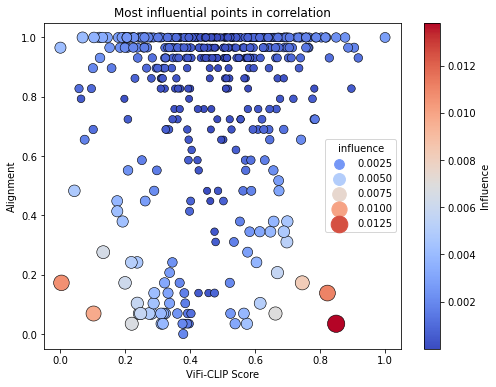

In [58]:
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    x=merged_df["score"],
    y=merged_df["alignment"],
    size=merged_df["influence"],
    hue=merged_df["influence"],
    palette="coolwarm",
    edgecolor="black",
    sizes=(50, 300),
    legend=True,
)

plt.xlabel("ViFi-CLIP Score")
plt.ylabel("Alignment")
plt.title("Most influential points in correlation")

norm = plt.Normalize(merged_df["influence"].min(), merged_df["influence"].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
plt.colorbar(sm, label="Influence")

plt.show()

# Analyze Correlation for Each Category

In this step, **GPT-4o** is used to classify each individual data point into four predefined categories. The classification process is carried out in the file `prompt_classification_gpt.ipynb`. The categories are as follows:

## Semantic Category
Instructions are grouped based on the intended modification type:

- **Object Addition**: Adds new objects to the scene.
    - Example: "Add a cat", "Put a table in front"
- **Object Removal**: Removes objects from the scene.
    - Example: "Remove the car", "Get rid of the vase"
- **Object Replacement**: Replaces one object with another.
    - Example: "Replace the dog with a cat", "Swap the bus for a truck"
- **Color Changes**: Changes the color of objects.
    - Example: "Make the hat red", "Change the hair color to pink"
- **Attribute Changes**: Modifies non-physical attributes of objects.
    - Example: "Make the man smile", "Let the woman have blonde hair"
- **Scene Changes**: Alters the environment or background of the scene.
    - Example: "Let the background be a forest", "Turn the sky dark"

## Instruction Type
Instructions are categorized by their tone or command style:

- **Imperative (Command)**: Direct instructions.
    - Example: "Add a cat", "Make the sky darker"
- **Interrogative (Question)**: Poses a question or suggestion.
    - Example: "What if the car was blue?", "Could the woman hold a banana?"

## Visual Impact
Classifies the extent of the visual changes prompted by the instructions:

- **Subtle Edits**: Minor changes to the scene.
    - Example: "Make the sky slightly darker", "Change the plate color to blue"
- **Moderate Edits**: Moderate changes that affect the scene's look but not drastically.
    - Example: "Add a dog in the grass", "Give the man a hat"
- **Drastic Edits**: Major changes to the scene.
    - Example: "Replace the car with a bus", "Remove all people from the scene"

## Object Type
Groups instructions based on the object or subject being modified:

- **Animals**: Modifies animals in the scene.
    - Example: "Add a dog", "Replace the cat with a fox"
- **People**: Alters people in the scene.
    - Example: "Make the man smile", "Give the woman a red dress"
- **Furniture/Objects**: Changes or removes furniture or objects.
    - Example: "Put a table in the room", "Remove the chair"
- **Vehicles**: Alters vehicles in the scene.
    - Example: "Change the truck into a taxi", "Let the motorcycle be a bicycle"
- **Food**: Modifies food items in the scene.
    - Example: "Make the cake a chocolate cake", "Replace the sandwich with a salad"
- **Background/Scene**: Alters the environment or background of the scene.
    - Example: "Turn the mountain into a waterfall", "Add a city in the background"


In [13]:
# add categories to df
categories = pd.read_csv("categories.csv")
merged_df = pd.merge(merged_df, categories, on=["turn", "id"])

In [14]:
merged_df.head()

,id,turn,score,_id,alignment,quality,consistency,overall,semantic_category,instruction_type,visual_impact,object_type
0,34,1,27.9030,677d856e8640497613a5ebe3,10.000,10.000,9.667,10.000,Object Removal,Imperative,Moderate Edit,Animals
1,34,2,28.0906,677d856e8640497613a5ebe4,10.000,8.000,9.667,9.333,Attribute Changes,Imperative,Moderate Edit,Animals
2,49,1,22.8624,677d856e8640497613a5ea9d,1.000,9.667,10.000,1.667,Object Removal,Imperative,Moderate Edit,People
3,49,2,20.0844,677d856e8640497613a5ea9e,7.333,2.667,2.667,3.333,Object Addition,Imperative,Moderate Edit,Background/Scene
4,49,3,19.9532,677d856e8640497613a5ea9f,2.000,2.333,2.333,2.000,Object Addition,Imperative,Moderate Edit,Background/Scene


Get groups for each category.

In [61]:
cat_columns = ["semantic_category", "instruction_type", "visual_impact", "object_type"]

for cat in cat_columns:
    category_counts = merged_df[cat].value_counts()

    category_counts_df = category_counts.reset_index()
    category_counts_df.columns = ["category", "count"]

    print(category_counts_df)

             category  count
0     Object Addition    200
1  Object Replacement    106
2   Attribute Changes     66
3       Color Changes     45
4      Object Removal     43
5       Scene Changes     14
        category  count
0     Imperative    448
1  Interrogative     26
        category  count
0  Moderate Edit    286
1    Subtle Edit    168
2   Drastic Edit     20
              category  count
0    Furniture/Objects    145
1              Animals     88
2               People     75
3                 Food     65
4     Background/Scene     61
5             Vehicles     29
6             Clothing      4
7              Objects      3
8               Plants      2
9   Clothing/Equipment      1
10               Other      1


Plot distribution of classes within each category.

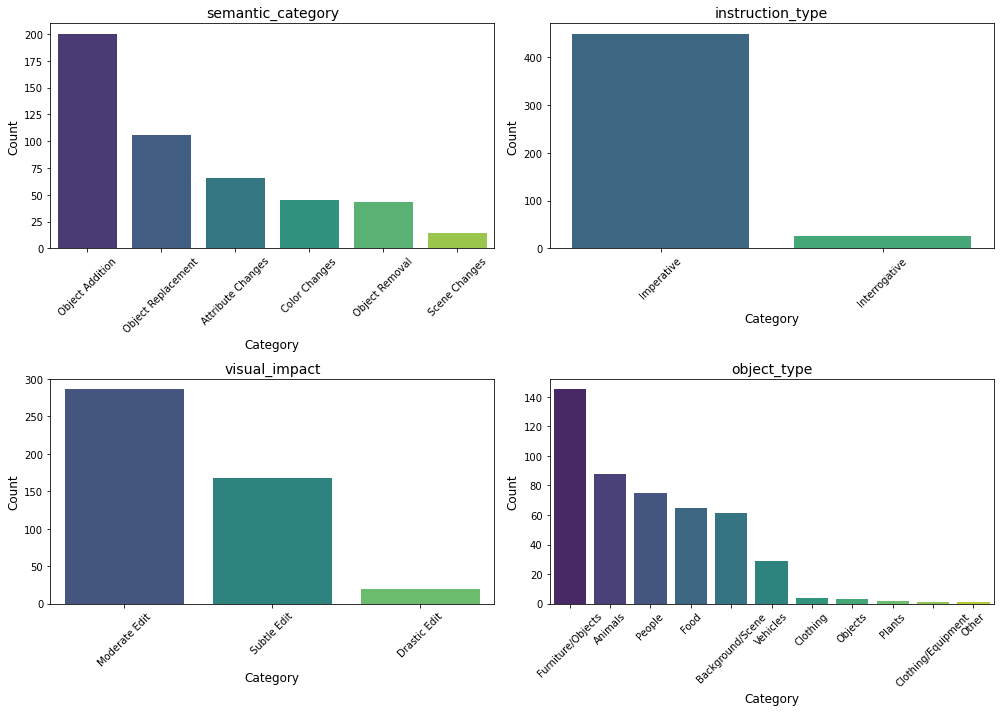

In [62]:
cat_columns = ["semantic_category", "instruction_type", "visual_impact", "object_type"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, cat in enumerate(cat_columns):
    category_counts = merged_df[cat].value_counts()
    category_counts_df = category_counts.reset_index()
    category_counts_df.columns = ["category", "count"]

    sns.barplot(
        data=category_counts_df, x="category", y="count", ax=axes[i], palette="viridis"
    )
    axes[i].set_title(cat, fontsize=14)
    axes[i].set_xlabel("Category", fontsize=12)
    axes[i].set_ylabel("Count", fontsize=12)
    axes[i].tick_params(axis="x", rotation=45, labelsize=10)

plt.tight_layout()
plt.show()

## Scatter Plots

In [63]:
def get_scatterplot_for_cat(category=None, save_path=None, split_by_category=False):
    if not category:
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(
            merged_df["score"],
            merged_df["alignment"],
            c=merged_df["alignment"],
            cmap="viridis",
            label="Alignment",
            edgecolors="k",
        )
        plt.colorbar(scatter, label="Alignment")
        plt.xlabel("ViFi-Score", fontsize=14)
        plt.ylabel("Alignment", fontsize=14)
        plt.title("Scatterplot: ViFi-Score vs. Alignment", fontsize=16)
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.show()
        return

    unique_categories = merged_df[category].unique()

    if split_by_category:
        # one scatter plot for each category
        n_categories = len(unique_categories)
        n_cols = 3
        n_rows = (n_categories + n_cols - 1) // n_cols

        fig, axes = plt.subplots(
            n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), constrained_layout=True
        )
        axes = axes.flatten()

        for i, cat in enumerate(unique_categories):
            ax = axes[i]
            subset = merged_df[merged_df[category] == cat]
            ax.scatter(
                subset["score"],
                subset["alignment"],
                c=subset["alignment"],
                cmap="viridis",
                edgecolors="k",
            )
            ax.set_title(f"{category}: {cat}")
            ax.set_xlabel("ViFi-Score")
            ax.set_ylabel("Alignment")

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.show()

    else:
        # scatter plot with colors for each category
        color_palette = sns.color_palette("Set1", len(unique_categories))
        category_colors = {
            cat: color_palette[i] for i, cat in enumerate(unique_categories)
        }

        merged_df["color"] = merged_df[category].map(category_colors)

        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(
            merged_df["score"],
            merged_df["alignment"],
            c=merged_df["color"],
            edgecolors="k",
        )

        handles = [
            plt.Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                label=cat,
                markerfacecolor=category_colors[cat],
                markersize=10,
            )
            for cat in unique_categories
        ]
        plt.legend(handles=handles, title="Categories")

        plt.xlabel("ViFi-Score", fontsize=14)
        plt.ylabel("Alignment", fontsize=14)
        plt.title("Scatterplot: ViFi-Score vs. Alignment", fontsize=16)
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.show()

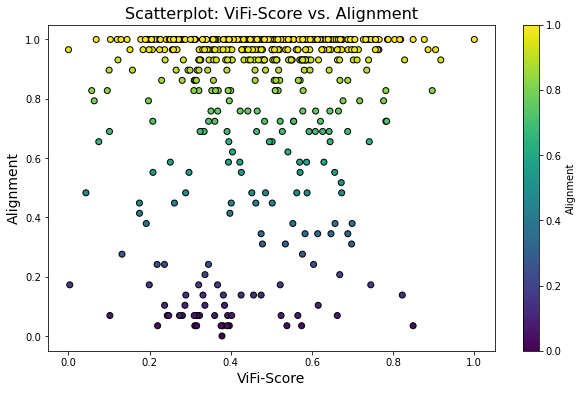

In [64]:
get_scatterplot_for_cat(save_path=None)  # "plots/scatterplot.png")

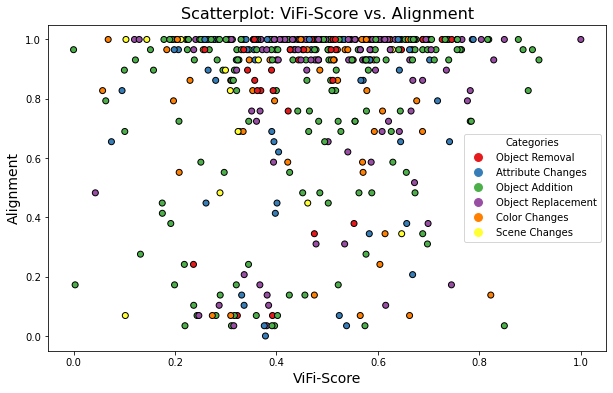

In [65]:
get_scatterplot_for_cat(cat_columns[0])

In [66]:
scaler = MinMaxScaler()
merged_df[["score", "alignment", "quality", "consistency", "overall"]] = (
    scaler.fit_transform(
        merged_df[["score", "alignment", "quality", "consistency", "overall"]]
    )
)

In [67]:
# similar method as above, but computes correlation between ViFi and humans for each category
def get_correlation_df(merged_df, cat):
    correlation_results = []

    merged_df = merged_df.dropna(
        subset=["score", "alignment", "quality", "consistency", "overall"]
    )
    grouped = merged_df.groupby(cat)
    category_counts = grouped.size()

    # iterate through each category
    for category, group in grouped:
        for col in ["alignment", "quality", "consistency", "overall"]:
            spearman_corr, spearman_p_value = stats.spearmanr(
                group["score"], group[col]
            )

            correlation_results.append(
                {
                    "category": category,
                    "df1": "score",
                    "df2": col,
                    "spearman_corr": spearman_corr,
                    "spearman_p_value": spearman_p_value,
                    "category_count": category_counts[
                        category
                    ],  # Add the count for the category
                }
            )

    correlation_results_df = pd.DataFrame(correlation_results)
    return correlation_results_df

In [68]:
cat_columns_correlation = list()
for index, cat in enumerate(cat_columns):
    cat_columns_correlation.append(get_correlation_df(merged_df, cat))

In [71]:
def plot_spearman_correlation(
    correlation_results_df, category_name, min_category_count=0, save_path=None
):
    # filter df to include only categories with at least x occurrences
    filtered_df = correlation_results_df[
        correlation_results_df["category_count"] >= min_category_count
    ]

    color_palette = sns.color_palette(n_colors=len(filtered_df["category"].unique()))

    plt.figure(figsize=(12, 6))
    bar_plot = sns.barplot(
        data=filtered_df,
        x="df2",
        y="spearman_corr",
        hue="category",
        palette=color_palette,
    )

    plt.axhline(0, color="grey", linewidth=0.8, linestyle="--")
    plt.title(
        f'Spearman Correlation Coefficients ({category_name.replace("_", " ")} & aspects)',
        fontsize=14,
    )
    plt.xlabel("", fontsize=14)
    plt.ylabel("Spearman's ρ", fontsize=14)

    plt.xticks(fontsize=12)

    # count occurrences of each category
    category_counts = filtered_df.groupby("category")["category_count"].max()

    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = [f"{label} (n={category_counts[label]})" for label in labels]

    plt.legend(
        handles=handles,
        labels=new_labels,
        title=category_name.replace("_", " "),
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=10,
    )

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

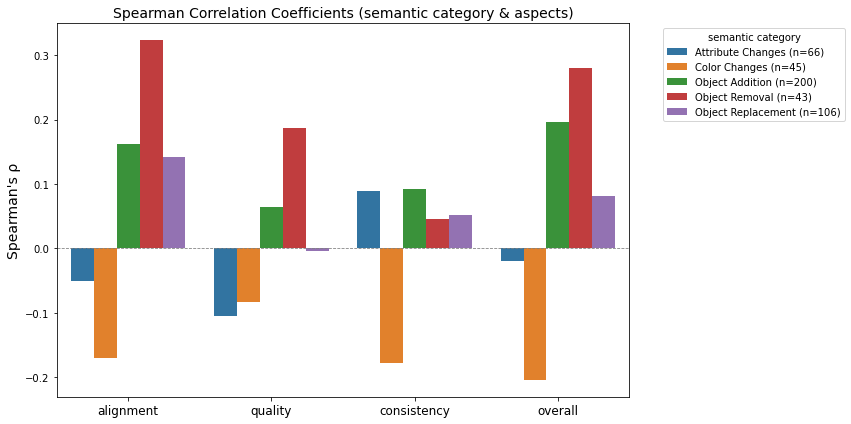

In [72]:
# print one detailed figure for a specified category
plot_spearman_correlation(
    cat_columns_correlation[0],
    cat_columns[0],
    min_category_count=20,
    # save_path="plots/scc_object_type.png"
)

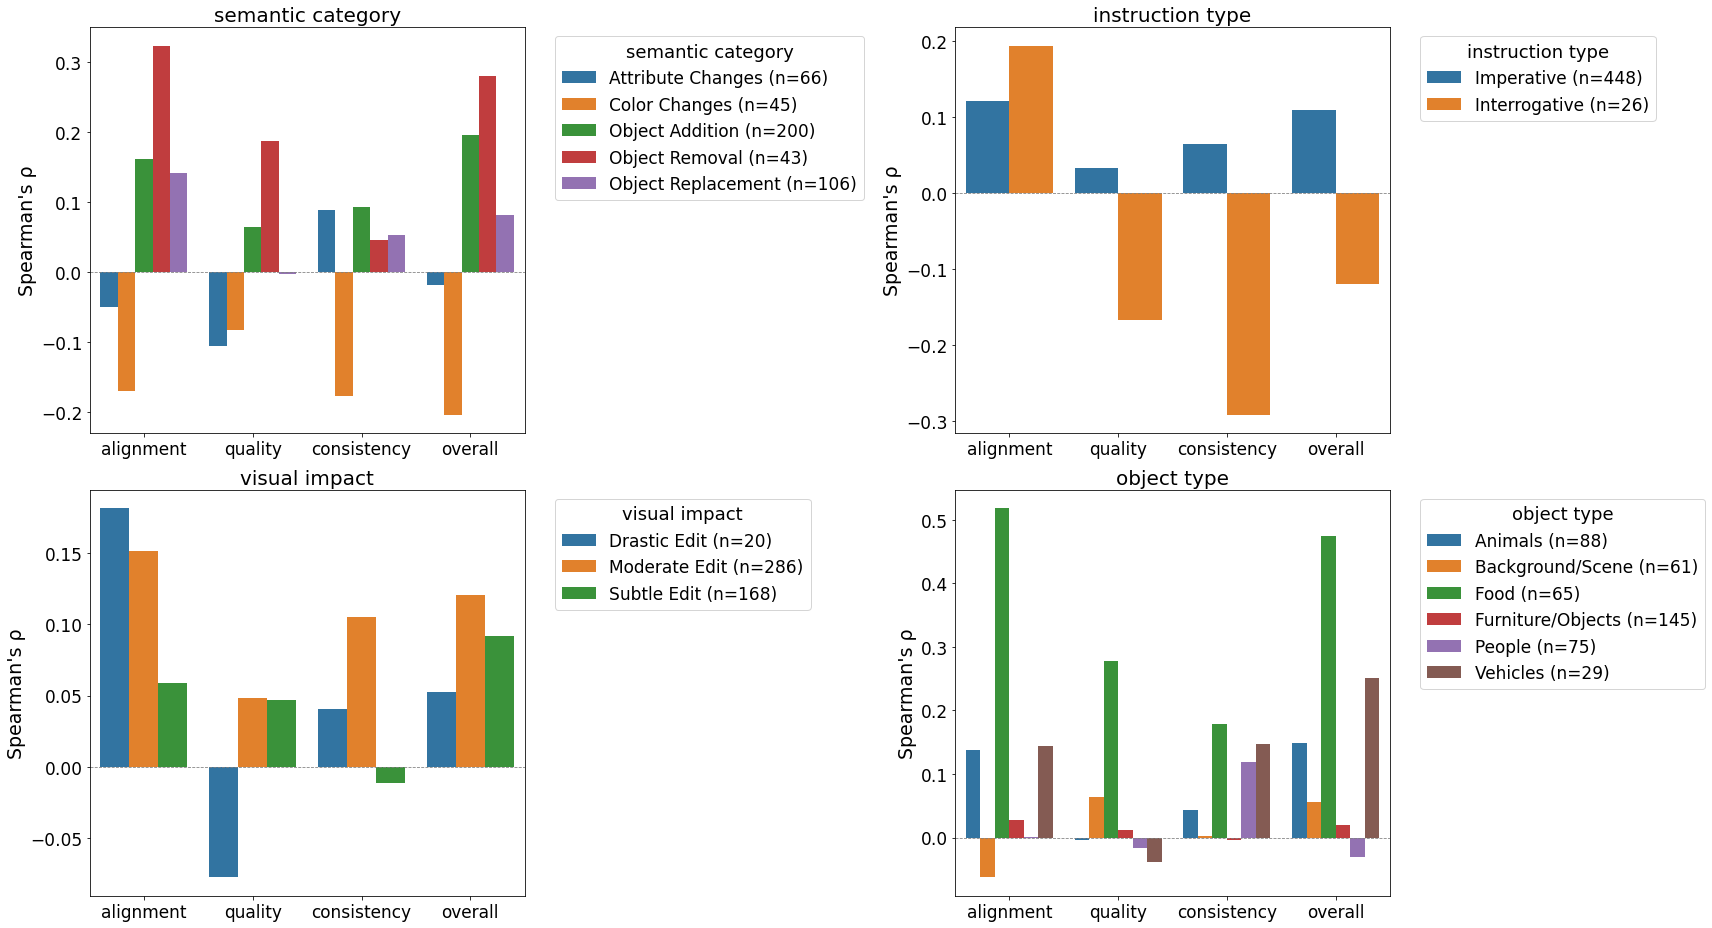

In [79]:
# plot figure containing the correlation for ALL categories
def plot_spearman_correlation(
    correlation_results_df, category_name, min_category_count=0, save_path=None, ax=None
):
    # filter df to include only categories with at least x occurrences
    filtered_df = correlation_results_df[
        correlation_results_df["category_count"] >= min_category_count
    ]
    color_palette = sns.color_palette(n_colors=len(filtered_df["category"].unique()))

    if ax is None:
        plt.figure(figsize=(12, 6))
        ax = plt.gca()

    sns.barplot(
        data=filtered_df,
        x="df2",
        y="spearman_corr",
        hue="category",
        palette=color_palette,
        ax=ax,
    )

    ax.axhline(0, color="grey", linewidth=0.8, linestyle="--")

    ax.set_title(f'{category_name.replace("_", " ")}', fontsize=20)

    ax.set_xlabel("", fontsize=19)
    ax.set_ylabel("Spearman's ρ", fontsize=19)
    ax.tick_params(axis="x", labelsize=17)
    ax.tick_params(axis="y", labelsize=17)

    category_counts = filtered_df.groupby("category")[
        "category_count"
    ].max()  # Get max count for each category

    handles, labels = ax.get_legend_handles_labels()
    new_labels = [f"{label} (n={category_counts[label]})" for label in labels]

    ax.legend(
        handles=handles,
        labels=new_labels,
        title=category_name.replace("_", " "),
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=17,
        title_fontsize=18,
    )


fig, axes = plt.subplots(2, 2, figsize=(24, 13))

for i, cat_column in enumerate(cat_columns_correlation[:4]):
    plot_spearman_correlation(
        cat_column,
        cat_columns[i],
        min_category_count=20,
        save_path=None,
        ax=axes[i // 2, i % 2],
    )

plt.tight_layout()
plt.savefig("plots/scc_overall.png", dpi=300, bbox_inches="tight")
plt.show()

Check which categories occurred in the subset of only good and bad edits, to potentially explain decreased correlation.

In [37]:
sample = pd.read_csv("annotations_mean_4_78.csv")
merged_df = pd.merge(categories, sample, on=["turn", "id"])

Categories of the subset, which primarily contains only good and bad rated edits.

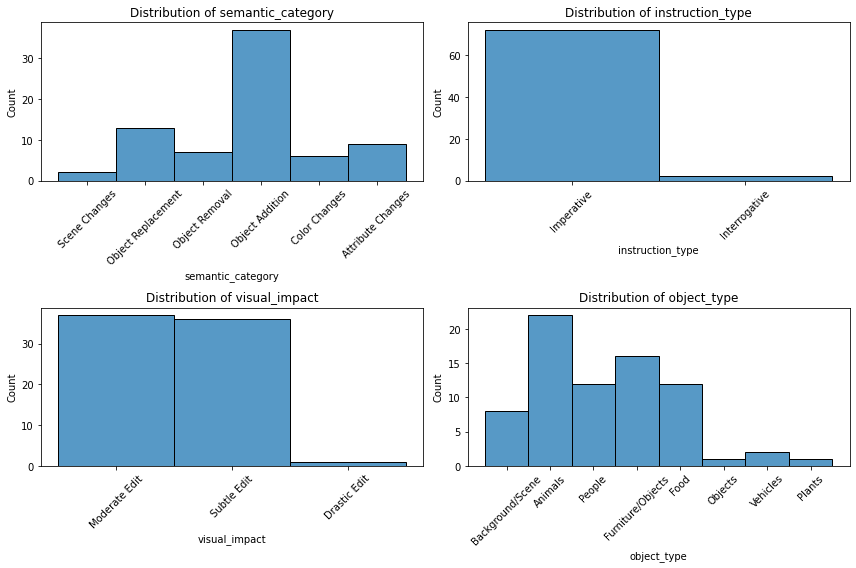

In [39]:
columns = ["semantic_category", "instruction_type", "visual_impact", "object_type"]

plt.figure(figsize=(12, 8))

for i, col in enumerate(columns, 1):
    plt.subplot(2, 2, i)  # 2x2 grid
    sns.histplot(merged_df[col], discrete=True, kde=False)
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

## Qualitative Analysis
Compute the largest differences between the ratings of ViFi and humans.

In [81]:
def get_top_differences(df, metric, top_n=10):
    df["diff"] = (df[metric] - df["score"]).abs()
    top_diff = df.nlargest(top_n, "diff")[["id", "turn"]]
    return top_diff


# top 10 differences
top_alignment = get_top_differences(merged_df, "alignment")
top_quality = get_top_differences(merged_df, "quality")
top_consistency = get_top_differences(merged_df, "consistency")
top_overall = get_top_differences(merged_df, "overall")

top_alignment, top_quality, top_consistency, top_overall

(         id  turn
 144  147745     1
 431  532493     1
 299  352426     3
 284  329847     3
 292  336015     2
 115  112286     2
 78    75065     3
 37    25139     1
 100  102625     1
 121  125106     2,
          id  turn
 261  292451     3
 40    25989     3
 163  175584     2
 218  229301     3
 431  532493     1
 364  422328     3
 359  417830     2
 9       853     2
 292  336015     2
 401  483587     2,
          id  turn
 261  292451     3
 367  422921     3
 40    25989     3
 218  229301     3
 431  532493     1
 163  175584     2
 364  422328     3
 115  112286     2
 419  519172     2
 242  266961     2,
          id  turn
 431  532493     1
 40    25989     3
 299  352426     3
 37    25139     1
 163  175584     2
 9       853     2
 292  336015     2
 54    45999     3
 401  483587     2
 218  229301     3)

In [86]:
# see detailed differences
merged_df[(merged_df["id"] == 229301) & (merged_df["turn"] == 3)]

,id,turn,score,_id,alignment,quality,consistency,overall,influence,semantic_category,instruction_type,visual_impact,object_type,color,diff
218,229301,3,0.063469,677d856e8640497613a5ebf5,0.793111,0.925889,0.963,0.857173,0.000501,Object Addition,Imperative,Subtle Edit,Animals,"(0.30196078431372547, 0.6862745098039216, 0.29...",0.793705


In [94]:
# get samples with high vifi predictions, low overall human scores
def get_high_score_low_overall(df, top_n=5):
    return df.nsmallest(top_n, "consistency").nlargest(top_n, "score")[
        ["id", "turn", "score", "overall"]
    ]


high_score_low_overall = get_high_score_low_overall(merged_df)
high_score_low_overall

,id,turn,score,overall
333,392837,3,0.587917,0.142827
51,44437,2,0.562633,0.214293
3,49,2,0.207794,0.285653
4,49,3,0.199087,0.142827
144,147745,1,0.000000,0.249973
